## Dominant-hand filtering and technique-specific blanking for `data.csv`

This notebook:
1. Loads `data.csv`.
2. Infers each participant's dominant hand via paired t-tests on left/right metrics.
3. Blanks the non-dominant hand measurements (per participant) and blanks columns by technique.
4. Drops unnamed columns left over from CSV export.
5. Runs recursive feature elimination (RFE, sklearn equivalent of R caret) with linear regression.


In [51]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

raw_path = "data_w_time.csv"
df = pd.read_csv(raw_path)
print(f"Loaded {len(df)} rows and {df.shape[1]} columns from {raw_path}")
df.head()

Loaded 480 rows and 33 columns from data_w_time.csv


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,targetEnteredCount,axisCrossedCount,trialTime,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,P001,Impaired,Astral,1.0,1.0,0.90,0.32,1.00,0.35,0.20,...,13.0,22.0,12.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P001,Impaired,Chicken,1.0,2.0,1.70,0.65,0.50,0.22,0.25,...,11.0,20.0,21.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P001,Impaired,Grab,2.0,1.0,1.10,0.42,2.60,0.85,0.50,...,14.0,28.0,15.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P001,Impaired,Sliding,2.0,2.0,1.30,0.52,1.05,0.34,0.30,...,13.0,24.0,16.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P001,Impaired,Teleport,3.0,1.0,1.25,0.50,1.60,0.62,0.30,...,15.0,30.0,13.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Metrics used to infer dominance
We test the mean difference between left and right values for the following pairs (paired t-test, alpha=0.05):
- Total distance
- Extent
- Thumbstick distance and extent
- Trigger pressure
- Grip pressure
- Head distance


In [52]:
hand_pairs = [
    ("leftTotalDistance", "rightTotalDistance", "totalDistance"),
    ("leftExtent", "rightExtent", "extent"),
    ("leftThumbstickDistance", "rightThumbstickDistance", "thumbstickDistance"),
    ("leftThumbstickExtent", "rightThumbstickExtent", "thumbstickExtent"),
    ("leftTriggerPressure", "rightTriggerPressure", "triggerPressure"),
    ("leftGripPressure", "rightGripPressure", "gripPressure"),
    ("leftHeadDistance", "rightHeadDistance", "headDistance"),
]

alpha = 0.05

def infer_dominant_hand(frame, pairs, alpha=0.05):
    dominant = {}
    rows = []
    for pid, group in frame.groupby("iD"):
        votes = []
        for left, right, label in pairs:
            cols = group[[left, right]].dropna()
            if len(cols) < 2:
                continue
            stat, p = ttest_rel(cols[left], cols[right])
            if np.isnan(p):
                continue
            mean_diff = cols[right].mean() - cols[left].mean()
            if p < alpha:
                votes.append(np.sign(mean_diff))
            rows.append({
                "iD": pid,
                "metric": label,
                "left_mean": cols[left].mean(),
                "right_mean": cols[right].mean(),
                "mean_diff": mean_diff,
                "p_value": p,
            })
        if votes:
            score = np.sign(np.sum(votes))
            if score > 0:
                dominant[pid] = "Right"
            elif score < 0:
                dominant[pid] = "Left"
            else:
                dominant[pid] = "Ambiguous"
        else:
            dominant[pid] = "Ambiguous"
    detail_df = pd.DataFrame(rows)
    return dominant, detail_df


In [53]:
dominant_map, ttest_details = infer_dominant_hand(df, hand_pairs, alpha)
dominant_hand_series = df["iD"].map(dominant_map)

print("Dominant hand per participant (computed, not added to dataset):")
dominant_hand_overview = pd.DataFrame(
    sorted(dominant_map.items()), columns=["iD", "dominant_hand"]
)
print(dominant_hand_overview)
print("\nSample of t-test details (per participant x metric):")
display(ttest_details.head())


Dominant hand per participant (computed, not added to dataset):
      iD dominant_hand
0   P001          Left
1   P002         Right
2   P003         Right
3   P004         Right
4   P005         Right
..   ...           ...
64  P065          Left
65  P066     Ambiguous
66  P067     Ambiguous
67  P068     Ambiguous
68  P069     Ambiguous

[69 rows x 2 columns]

Sample of t-test details (per participant x metric):


/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,iD,metric,left_mean,right_mean,mean_diff,p_value
0,P001,totalDistance,1.508333,0.333333,-1.175000,0.009660
1,P001,extent,0.555000,0.153333,-0.401667,0.011783
2,P001,thumbstickDistance,0.560000,0.090000,-0.470000,0.187298
3,P001,thumbstickExtent,0.283333,0.065000,-0.218333,0.060078
4,P001,triggerPressure,0.323333,0.050000,-0.273333,0.115924


In [54]:
clean_df = df.copy()
right_mask = dominant_hand_series == "Right"
left_mask = dominant_hand_series == "Left"

for left, right, _ in hand_pairs:
    clean_df.loc[right_mask, left] = np.nan
    clean_df.loc[left_mask, right] = np.nan

clean_df.head()


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,targetEnteredCount,axisCrossedCount,trialTime,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,P001,Impaired,Astral,1.0,1.0,0.90,0.32,1.00,0.35,NaN,...,13.0,22.0,12.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P001,Impaired,Chicken,1.0,2.0,1.70,0.65,0.50,0.22,NaN,...,11.0,20.0,21.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P001,Impaired,Grab,2.0,1.0,1.10,0.42,2.60,0.85,NaN,...,14.0,28.0,15.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P001,Impaired,Sliding,2.0,2.0,1.30,0.52,1.05,0.34,NaN,...,13.0,24.0,16.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P001,Impaired,Teleport,3.0,1.0,1.25,0.50,1.60,0.62,NaN,...,15.0,30.0,13.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Technique-specific blanking
- `Chicken`: blank all hand-related columns (left/right position, thumbstick, trigger/grip, and head-distance-by-hand) and corresponding `dominant_*` hand columns.
- `Astral`, `Grab`, `Sliding`, `Teleport`, `Throw`: blank head-related columns and `dominant_headDistance`.


In [55]:
hand_cols = [
    "leftTotalDistance", "rightTotalDistance",
    "leftExtent", "rightExtent",
    "leftHeadDistance", "rightHeadDistance",
    "leftThumbstickDistance", "rightThumbstickDistance",
    "leftThumbstickExtent", "rightThumbstickExtent",
    "leftTriggerPressure", "rightTriggerPressure",
    "leftGripPressure", "rightGripPressure",
]

head_cols = ["headTotalDistance", "headExtent"]

chicken_mask = clean_df["technique"] == "Chicken"
clean_df.loc[chicken_mask, hand_cols] = np.nan

head_mask = clean_df["technique"].isin(["Astral", "Grab", "Sliding", "Teleport", "Throw"])
clean_df.loc[head_mask, head_cols] = np.nan

print("Applied technique-specific blanking:")
print(f"Hand columns blanked for Chicken rows: {chicken_mask.sum()} rows")
print(f"Head columns blanked for Astral/Grab/Sliding/Teleport/Throw rows: {head_mask.sum()} rows")

clean_df.head()


Applied technique-specific blanking:
Hand columns blanked for Chicken rows: 69 rows
Head columns blanked for Astral/Grab/Sliding/Teleport/Throw rows: 345 rows


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,targetEnteredCount,axisCrossedCount,trialTime,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,P001,Impaired,Astral,1.0,1.0,NaN,NaN,1.00,0.35,NaN,...,13.0,22.0,12.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P001,Impaired,Chicken,1.0,2.0,1.7,0.65,NaN,NaN,NaN,...,11.0,20.0,21.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P001,Impaired,Grab,2.0,1.0,NaN,NaN,2.60,0.85,NaN,...,14.0,28.0,15.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P001,Impaired,Sliding,2.0,2.0,NaN,NaN,1.05,0.34,NaN,...,13.0,24.0,16.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P001,Impaired,Teleport,3.0,1.0,NaN,NaN,1.60,0.62,NaN,...,15.0,30.0,13.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# Drop unnamed columns created by CSV export artifacts
unnamed_cols = [c for c in clean_df.columns if c.lower().startswith("unnamed")]
if unnamed_cols:
    clean_df = clean_df.drop(columns=unnamed_cols)
    print(f"Dropped {len(unnamed_cols)} unnamed column(s): {unnamed_cols}")
else:
    print("No unnamed columns to drop.")
clean_df.head()

Dropped 7 unnamed column(s): ['Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32']


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,rightThumbstickExtent,leftTriggerPressure,rightTriggerPressure,leftGripPressure,rightGripPressure,buttonPressCount,movementVariability,targetEnteredCount,axisCrossedCount,trialTime
0,P001,Impaired,Astral,1.0,1.0,NaN,NaN,1.00,0.35,NaN,...,NaN,0.05,NaN,0.03,NaN,20.0,0.90,13.0,22.0,12.76
1,P001,Impaired,Chicken,1.0,2.0,1.7,0.65,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.95,11.0,20.0,21.12
2,P001,Impaired,Grab,2.0,1.0,NaN,NaN,2.60,0.85,NaN,...,NaN,0.80,NaN,0.20,NaN,6.0,1.05,14.0,28.0,15.12
3,P001,Impaired,Sliding,2.0,2.0,NaN,NaN,1.05,0.34,NaN,...,NaN,0.06,NaN,0.05,NaN,38.0,0.92,13.0,24.0,16.14
4,P001,Impaired,Teleport,3.0,1.0,NaN,NaN,1.60,0.62,NaN,...,NaN,0.85,NaN,0.12,NaN,18.0,1.00,15.0,30.0,13.20


### 特征选择：递归特征消除（RFE） + 线性回归
- 使用 sklearn 的 `RFE`（对应 R 中 caret 的 RFE 功能）并选择线性回归作为估计器。
- 目标变量：`trialTime`；去除标识列 `iD`，对分类特征做 one-hot 编码。
- 对清洗后产生的缺失值使用列中位数填充，以便模型训练。


In [57]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Prepare data for RFE
target_col = "trialTime"
model_df = clean_df.dropna(subset=[target_col]).copy()

feature_cols = [c for c in model_df.columns if c not in [target_col, "iD"]]
feature_df = pd.get_dummies(model_df[feature_cols], drop_first=True)

# Fill blanks introduced by earlier cleaning with the median per column
feature_df = feature_df.apply(lambda col: col.fillna(col.median()))

X = feature_df.values
y = model_df[target_col].values

n_features = min(10, X.shape[1])  # keep top 10 features (or fewer if not available)
rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_features)
rfe.fit(X, y)

selected_features = feature_df.columns[rfe.support_]
ranking_df = pd.DataFrame(
    {"feature": feature_df.columns, "rank": rfe.ranking_, "selected": rfe.support_}
).sort_values(by=["rank", "feature"])

X_selected = rfe.transform(X)
r2 = rfe.estimator_.score(X_selected, y)

print(f"Selected top {len(selected_features)} features (of {feature_df.shape[1]} candidates) to predict {target_col}.")
print(f"Training R^2 using selected features: {r2:.3f}")
display(pd.DataFrame(selected_features, columns=["selected_feature"]))
display(ranking_df.head(20))

Selected top 10 features (of 27 candidates) to predict trialTime.
Training R^2 using selected features: 0.429


,selected_feature
0,headTotalDistance
1,headExtent
2,rightExtent
3,rightHeadDistance
4,leftThumbstickDistance
5,leftThumbstickExtent
6,leftGripPressure
7,movementVariability
8,technique_Chicken
9,technique_Throw


,feature,rank,selected
3,headExtent,1,True
2,headTotalDistance,1,True
16,leftGripPressure,1,True
10,leftThumbstickDistance,1,True
11,leftThumbstickExtent,1,True
19,movementVariability,1,True
7,rightExtent,1,True
9,rightHeadDistance,1,True
22,technique_Chicken,1,True
26,technique_Throw,1,True


In [58]:
clean_path = "data_cleaned.csv"
clean_df.to_csv(clean_path, index=False)
print(f"Saved cleaned data to {clean_path} after dropping unnamed columns.")

Saved cleaned data to data_cleaned.csv after dropping unnamed columns.


## 校准技术预测（随机森林回归）
- 轮流将 Astral、Chicken、Grab、Sliding、Teleport、Throw 作为校准技术，仅用该技术的数据训练。
- 目标：预测同一批参与者在其余五种技术上的 `trialTime`，技术列被从特征中移除以避免恒定列。
- 特征清洗：丢弃在当前校准技术中全为空的列；数值列用中位数填充，类别列用众数填充并独热编码。
- 模型：`RandomForestRegressor`；记录每个校准技术的 R² 和 MAE，并保留逐条预测。

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

rf_results = []
prediction_rows = []

techniques = sorted(clean_df["technique"].dropna().unique())
target_col = "trialTime"
base_feature_cols = [c for c in clean_df.columns if c not in [target_col, "iD", "technique"]]

for calibration_tech in techniques:
    train_df = clean_df[clean_df["technique"] == calibration_tech].dropna(subset=[target_col])
    test_df = clean_df[clean_df["technique"] != calibration_tech].dropna(subset=[target_col])

    # 丢弃在当前校准技术中完全缺失的列（例如 Chicken 的手部数据、Teleport 的头部数据）。
    usable_cols = [c for c in base_feature_cols if not train_df[c].isna().all()]
    X_train = train_df[usable_cols].copy()
    X_test = test_df[usable_cols].copy()
    y_train = train_df[target_col]
    y_test = test_df[target_col]

    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

    preprocessor = ColumnTransformer(
        [
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_cols),
            (
                "cat",
                Pipeline(
                    [
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore")),
                    ]
                ),
                categorical_cols,
            ),
        ]
    )

    rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
    model = Pipeline([("prep", preprocessor), ("rf", rf)])
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rf_results.append({"calibration": calibration_tech, "r2": r2, "mae": mae})

    prediction_rows.append(
        pd.DataFrame(
            {
                "calibration": calibration_tech,
                "technique": test_df["technique"].values,
                "iD": test_df["iD"].values,
                "actual": y_test.values,
                "predicted": preds,
            }
        )
    )

rf_summary = pd.DataFrame(rf_results).sort_values("calibration").reset_index(drop=True)
rf_predictions = pd.concat(prediction_rows, ignore_index=True)

print("校准技术随机森林结果：")
display(rf_summary)
print("预测样本预览：")
display(rf_predictions.head())


校准技术随机森林结果：


,calibration,r2,mae
0,Astral,-0.166486,5.898832
1,Chicken,-1.330714,10.141539
2,Grab,-0.018592,6.155634
3,Sliding,-0.006418,6.773764
4,Teleport,-0.141968,6.470458
5,Throw,-3.975539,13.783020


预测样本预览：


,calibration,technique,iD,actual,predicted
0,Astral,Chicken,P001,21.12,18.667494
1,Astral,Grab,P001,15.12,20.181627
2,Astral,Sliding,P001,16.14,15.652275
3,Astral,Teleport,P001,13.20,17.437502
4,Astral,Throw,P001,20.28,17.709220


### 可视化
- 左图：按校准技术的 R² 和 MAE 表现。
- 右图：预测值 vs. 真实值的散点，颜色表示校准技术，灰色虚线为理想的 1:1 线。

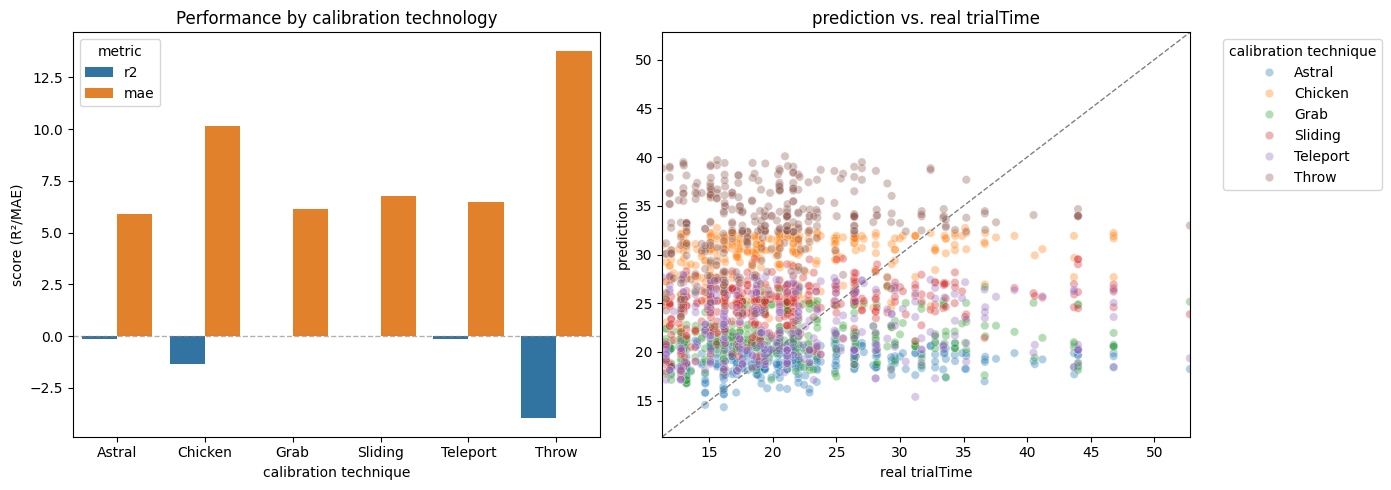

In [60]:
rf_summary_melt = rf_summary.melt(id_vars="calibration", value_vars=["r2", "mae"], var_name="metric")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=rf_summary_melt, x="calibration", y="value", hue="metric", ax=axes[0])
axes[0].set_title("Performance by calibration technology")
axes[0].set_ylabel("score (R²/MAE)")
axes[0].set_xlabel("calibration technique")
axes[0].axhline(0, color="gray", linewidth=1, linestyle="--", alpha=0.6)
axes[0].legend(title="metric")

rf_predictions["abs_error"] = (rf_predictions["predicted"] - rf_predictions["actual"]).abs()
lims = [
    min(rf_predictions["actual"].min(), rf_predictions["predicted"].min()),
    max(rf_predictions["actual"].max(), rf_predictions["predicted"].max()),
]

sns.scatterplot(
    data=rf_predictions,
    x="actual",
    y="predicted",
    hue="calibration",
    alpha=0.35,
    ax=axes[1],
)
axes[1].plot(lims, lims, linestyle="--", color="gray", linewidth=1)
axes[1].set_xlim(lims)
axes[1].set_ylim(lims)
axes[1].set_title("prediction vs. real trialTime")
axes[1].set_xlabel("real trialTime")
axes[1].set_ylabel("prediction")
axes[1].legend(title="calibration technique", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


## Elastic Net Regression for comparison
- Train Elastic Net (with alpha/l1-ratio tuning) using each calibration technique in turn.
- Same train/test split as the random forest: train on one technique, predict `trialTime` for the remaining techniques.
- Numeric features are median-imputed and standardized; categorical features are mode-imputed and one-hot encoded.
- Metrics recorded per calibration: R² and MAE. Also keep per-row predictions for plotting.

In [61]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

enet_results = []
enet_prediction_rows = []

alpha_grid = [0.01, 0.1, 1.0, 10.0]
l1_grid = [0.1, 0.5, 0.9]

for calibration_tech in techniques:
    train_df = clean_df[clean_df["technique"] == calibration_tech].dropna(subset=[target_col])
    test_df = clean_df[clean_df["technique"] != calibration_tech].dropna(subset=[target_col])
    usable_cols = [c for c in base_feature_cols if not train_df[c].isna().all()]
    X_train = train_df[usable_cols].copy()
    X_test = test_df[usable_cols].copy()
    y_train = train_df[target_col]
    y_test = test_df[target_col]

    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

    preprocessor = ColumnTransformer(
        [
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), numeric_cols),
            (
                "cat",
                Pipeline(
                    [
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore")),
                    ]
                ),
                categorical_cols,
            ),
        ]
    )

    enet = ElasticNet(max_iter=5000, random_state=42)
    param_grid = {"reg__alpha": alpha_grid, "reg__l1_ratio": l1_grid}
    model = Pipeline([("prep", preprocessor), ("reg", enet)])
    search = GridSearchCV(model, param_grid=param_grid, cv=3, n_jobs=-1)
    search.fit(X_train, y_train)
    preds = search.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    enet_results.append(
        {
            "calibration": calibration_tech,
            "r2": r2,
            "mae": mae,
            "best_alpha": search.best_params_["reg__alpha"],
            "best_l1_ratio": search.best_params_["reg__l1_ratio"],
        }
    )

    enet_prediction_rows.append(
        pd.DataFrame(
            {
                "calibration": calibration_tech,
                "technique": test_df["technique"].values,
                "iD": test_df["iD"].values,
                "actual": y_test.values,
                "predicted": preds,
            }
        )
    )

enet_summary = pd.DataFrame(enet_results).sort_values("calibration").reset_index(drop=True)
enet_predictions = pd.concat(enet_prediction_rows, ignore_index=True)

print("Calibration Elastic Net results:")
display(enet_summary)
print("Prediction sample:")
display(enet_predictions.head())


Calibration Elastic Net results:


,calibration,r2,mae,best_alpha,best_l1_ratio
0,Astral,-0.656763,7.206046,10.00,0.5
1,Chicken,-1.357285,10.244798,0.01,0.1
2,Grab,-9.941399,15.855947,0.10,0.9
3,Sliding,0.078303,5.980210,1.00,0.9
4,Teleport,-0.180867,6.011960,10.00,0.5
5,Throw,-1.525836,9.676708,10.00,0.5


Prediction sample:


,calibration,technique,iD,actual,predicted
0,Astral,Chicken,P001,21.12,16.09029
1,Astral,Grab,P001,15.12,16.09029
2,Astral,Sliding,P001,16.14,16.09029
3,Astral,Teleport,P001,13.20,16.09029
4,Astral,Throw,P001,20.28,16.09029


### Model comparison plots (English legends)
- Bar charts: R² and MAE per calibration technique, comparing Random Forest vs. Elastic Net.
- Scatter plots: predicted vs. actual `trialTime`, faceted by model; legend shows calibration technique.

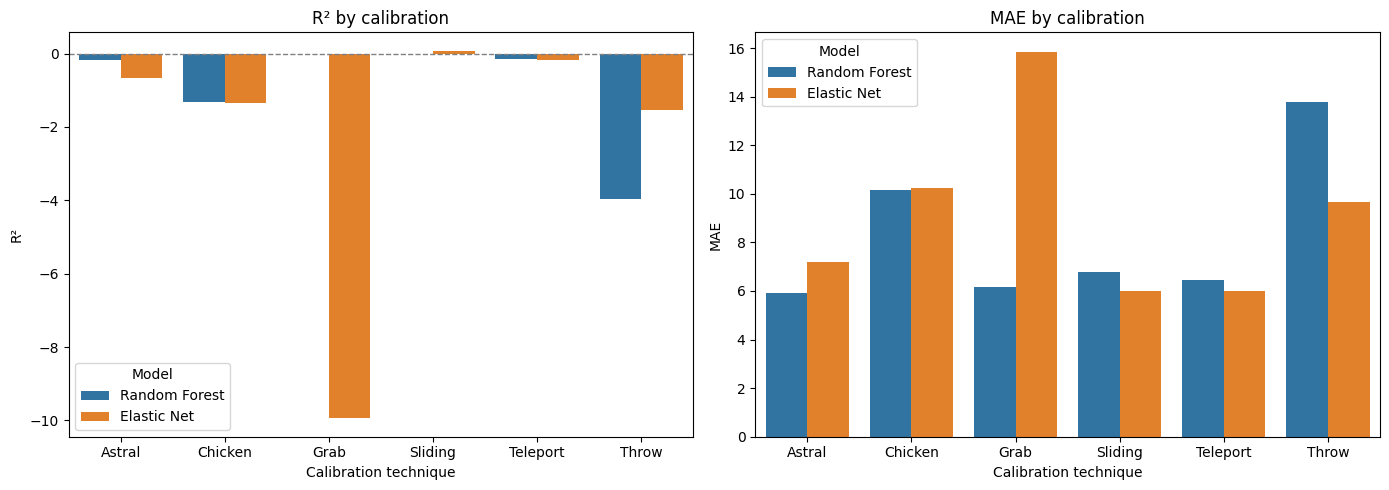

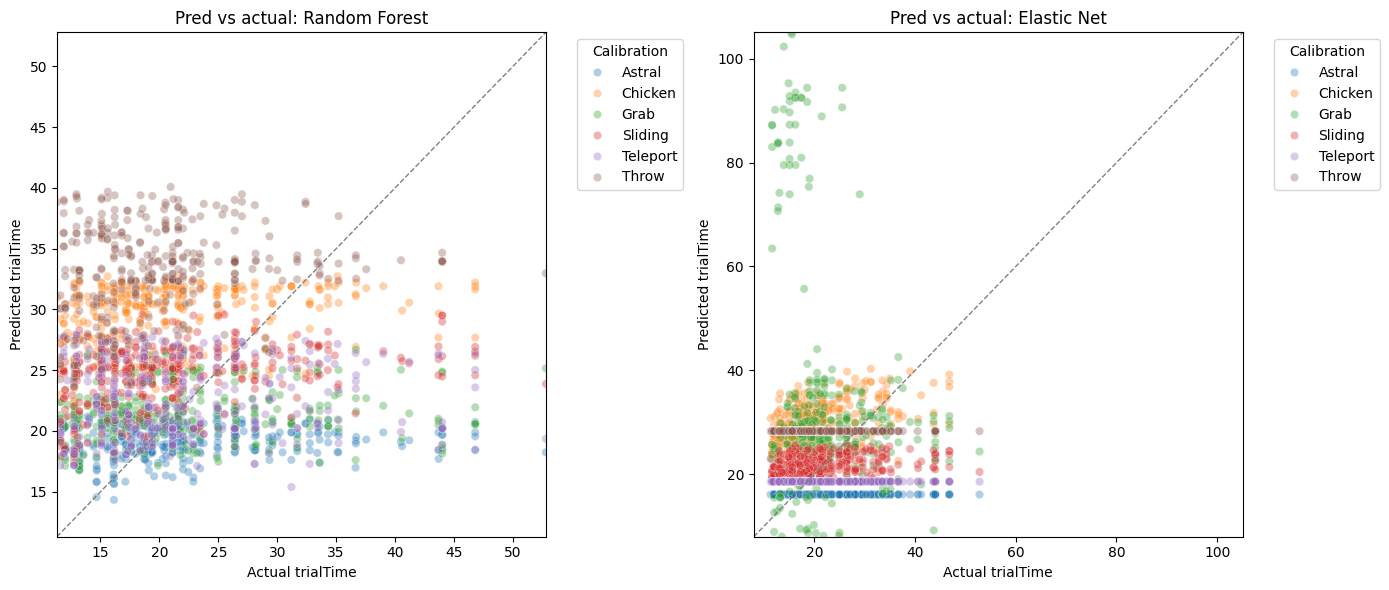

In [62]:
combined_summary = pd.concat([
    rf_summary.assign(model="Random Forest"),
    enet_summary.assign(model="Elastic Net"),
])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=combined_summary, x="calibration", y="r2", hue="model", ax=axes[0])
axes[0].set_title("R² by calibration")
axes[0].set_ylabel("R²")
axes[0].set_xlabel("Calibration technique")
axes[0].axhline(0, color="gray", linestyle="--", linewidth=1)
axes[0].legend(title="Model")

sns.barplot(data=combined_summary, x="calibration", y="mae", hue="model", ax=axes[1])
axes[1].set_title("MAE by calibration")
axes[1].set_ylabel("MAE")
axes[1].set_xlabel("Calibration technique")
axes[1].legend(title="Model")
plt.tight_layout()
plt.show()

rf_predictions["model"] = "Random Forest"
enet_predictions["model"] = "Elastic Net"
combined_predictions = pd.concat([rf_predictions, enet_predictions], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax, model_name in zip(axes, ["Random Forest", "Elastic Net"]):
    subset = combined_predictions[combined_predictions["model"] == model_name]
    lims = [
        min(subset["actual"].min(), subset["predicted"].min()),
        max(subset["actual"].max(), subset["predicted"].max()),
    ]
    sns.scatterplot(
        data=subset,
        x="actual",
        y="predicted",
        hue="calibration",
        alpha=0.35,
        ax=ax,
    )
    ax.plot(lims, lims, linestyle="--", color="gray", linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title(f"Pred vs actual: {model_name}")
    ax.set_xlabel("Actual trialTime")
    ax.set_ylabel("Predicted trialTime")
    ax.legend(title="Calibration", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()
